In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import python library/function for function optimization
import scipy.optimize

%config InlineBackend.figure_format = "retina"

In [2]:
s1 = pd.read_csv("../results/s1_vmr.csv")
s1.head()


,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,MT,RT,ST,adaptation,total error,theta_maxradv_z,theta_maxradv_outlier,theta_maxradv_mean,theta_maxradv_clean,movement_var
0,10,10,10_i,s,72,72,7.166301,96.298669,0.0,0.0,...,0.254234,0.277367,0.827275,NaN,NaN,2.343730,False,0.751571,5.997483,NaN
1,10,10,10_i,s,73,73,5.356301,83.058669,0.0,0.0,...,0.263561,0.320758,1.096920,-1.125141,-0.957654,1.023456,False,0.751571,3.042346,NaN
2,10,10,10_i,s,74,74,4.536301,89.088669,0.0,0.0,...,0.291127,0.365913,0.803508,NaN,NaN,1.841047,False,0.751571,4.872342,NaN
3,10,10,10_i,s,75,75,0.756301,83.528669,0.0,0.0,...,0.306791,0.322387,0.994904,-6.742887,-3.402225,-0.962257,False,0.751571,-1.402225,NaN
4,10,10,10_i,s,76,76,1.956301,84.828669,0.0,0.0,...,0.293896,0.370178,2.406434,NaN,NaN,-1.171490,False,0.751571,-1.870546,NaN


In [3]:
def state_ege(previous_state, ege, T, B, A=0):
    state_est = A * previous_state + B * (T - ege)
    
    return state_est


def pea(x_v, sigma_v, sigma_int, T, B):
    w_int = (1 / sigma_int**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    w_v = (1 / sigma_v**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    xhat_hand = w_v * x_v
    x_stl = B * (T - xhat_hand)
    
    return x_stl


def simulate_experiment(num_trials, x_hand_ege, sigma, vis_fb, delta_x, B):
    for i in range(num_trials - 1):
        if i == 0:
            x_hand_ege[i] = np.random.normal(0, sigma)

        if vis_fb[i] == 0:
            x_v = 0
            ege = 0
        else:
            ege = delta_x[i] 

        x_hand_ege[i + 1] = state_ege(x_hand_ege[i], ege, T, B) + np.random.normal(0, sigma)
    
    return x_hand_ege


def calculate_adaptation(num_trials, n_per_miniblock, x):
    adaptation = np.zeros(num_trials)
    adaptation[1::n_per_miniblock] = x[2::n_per_miniblock] - x[0:-1:n_per_miniblock]
    
    return adaptation

In [4]:
# Plotting functions
def plot_individual(df, ege, ige, adaptation,  title):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))
    sns.regplot(data=df, x=ege, x_jitter=0.1, y=adaptation, 
               scatter_kws={"alpha":0.4, "color":"gray"},  line_kws={"color":"r"}, ax=axs[0])
    axs[0].set(xlabel="rotation (deg)", ylabel="adaptation (deg)", xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), 
           ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2))
    axs[0].axhline(color="k", linewidth=0.5)

    sns.regplot(data=df, x=ige, y=adaptation, line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
    axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="internal error (deg)", ylabel="adaptation (deg)")
    axs[1].axhline(color="k", linewidth=0.5)

    fig.suptitle(title)
    plt.tight_layout()

In [5]:
# Simulated parameters
pert_size = np.array([-4, -2, 0, 2, 4])
n_per_pert = 100
n_per_miniblock = 2
num_trials = len(pert_size) * n_per_pert * n_per_miniblock + 1  # add 1 to get even number of adaptation measures
perts = np.repeat(pert_size, n_per_pert)
perts = np.random.permutation(perts)
pert_idx = np.arange(1, num_trials, n_per_miniblock)
prepert_idx = pert_idx - 1
postpert_idx = pert_idx + 1

delta_x = np.zeros(num_trials)
delta_x[pert_idx] = perts

# Test different fb schedules; names wrt which trials have vis fb
vis_fb_scheds = ["all", "pre pert", "post pert", "none", "mixed"]
vis_fb_sched = "mixed"
vis_fb = np.zeros(num_trials, dtype=bool)
if vis_fb_sched == "all":
    vis_fb = np.ones(num_trials, dtype=bool)
elif vis_fb_sched == "post pert":
    idx = np.sort(np.concatenate((pert_idx, postpert_idx)))
    vis_fb[idx] = 1
elif vis_fb_sched == "none":
    vis_fb[pert_idx] = 1
elif vis_fb_sched == "mixed":
    vis_fb = np.ones(num_trials, dtype="bool")
    idx = np.sort(np.random.choice(prepert_idx, size=int(len(prepert_idx) / 2), replace=False))
    vis_fb[idx] = 0
elif vis_fb_sched == "pre pert":
    idx = np.sort(np.concatenate((pert_idx, prepert_idx)))
    vis_fb[idx] = 1


In [6]:
# PEA params
sigma_motor = 1.8
sigma_int = 7.36

sigma_motor = 1.8
eps = np.random.normal(loc=0, scale=sigma_motor, size=num_trials)  # motor noise
x_stl = np.zeros(num_trials)  # PEA observer
x_hand_pea = np.zeros(num_trials)
x_hand_premo = np.zeros(num_trials)
x_totalerr = np.zeros(num_trials)  # hand angle of state estimator, learns from total error
x_hand_ege = np.zeros(num_trials)  # hand angle of state estimator, learns from ege only
x_hand_ege_mem = np.zeros(num_trials)  # state estimator with non-zero retention factor
T = 0
B = 0.7

# Loop through trials
for i in range(num_trials - 1):
    if i == 0:
        x_hand_ege[i] = eps[i]
        x_hand_pea[i] = eps[i]
        
    if vis_fb[i] == 0:
        x_v = 0
        sigma_v = np.inf
        ege = 0
    else:
        ege = delta_x[i] 
        x_v = x_hand_pea[i] + delta_x[i]
        sigma_v = 1.179 + 0.384 * np.abs(x_v)  # after Zhang et al
        
    x_hand_ege[i + 1] = state_ege(x_hand_ege[i], ege, T, B) + eps[i + 1]
    x_hand_pea[i + 1] = pea(x_v, sigma_v, sigma_int, T, B) + eps[i + 1]
    
# Compute adaptation metric
adapt_ege = np.zeros(num_trials)
adapt_ege[1::n_per_miniblock] = x_hand_ege[2::n_per_miniblock] - x_hand_ege[0:-1:n_per_miniblock]

adapt_pea = np.zeros(num_trials)
adapt_pea[1::n_per_miniblock] = x_hand_pea[2::n_per_miniblock] - x_hand_pea[0:-1:n_per_miniblock]

# Create data frame with all trials
df = pd.DataFrame({
    "delta_x":delta_x, 
    "x_hand_ege":x_hand_ege, 
    "adapt_ege": adapt_ege, 
    "x_hand_pea":x_hand_pea, 
    "adapt_pea":adapt_pea
})
df.head(15)

,delta_x,x_hand_ege,adapt_ege,x_hand_pea,adapt_pea
0,0.0,-1.420349,0.000000,-1.420349,0.000000
1,0.0,-2.444203,1.943769,-2.444203,3.523909
2,0.0,0.523421,0.000000,2.103560,0.000000
3,2.0,0.205053,-5.397306,-1.167429,-6.137042
4,0.0,-4.873886,0.000000,-4.033482,0.000000
5,0.0,-0.670297,6.130148,-0.670297,5.741736
6,0.0,1.256262,0.000000,1.708254,0.000000
7,0.0,-1.155328,0.726244,-1.155328,1.045494
8,0.0,1.982506,0.000000,2.753748,0.000000
9,-4.0,0.123893,2.390222,0.123893,1.217243


In [7]:
# Create trimmed data frame without null trials
df_adapt = df.iloc[1::n_per_miniblock].reset_index()
df_adapt.head()

,index,delta_x,x_hand_ege,adapt_ege,x_hand_pea,adapt_pea
0,1,0.0,-2.444203,1.943769,-2.444203,3.523909
1,3,2.0,0.205053,-5.397306,-1.167429,-6.137042
2,5,0.0,-0.670297,6.130148,-0.670297,5.741736
3,7,0.0,-1.155328,0.726244,-1.155328,1.045494
4,9,-4.0,0.123893,2.390222,0.123893,1.217243


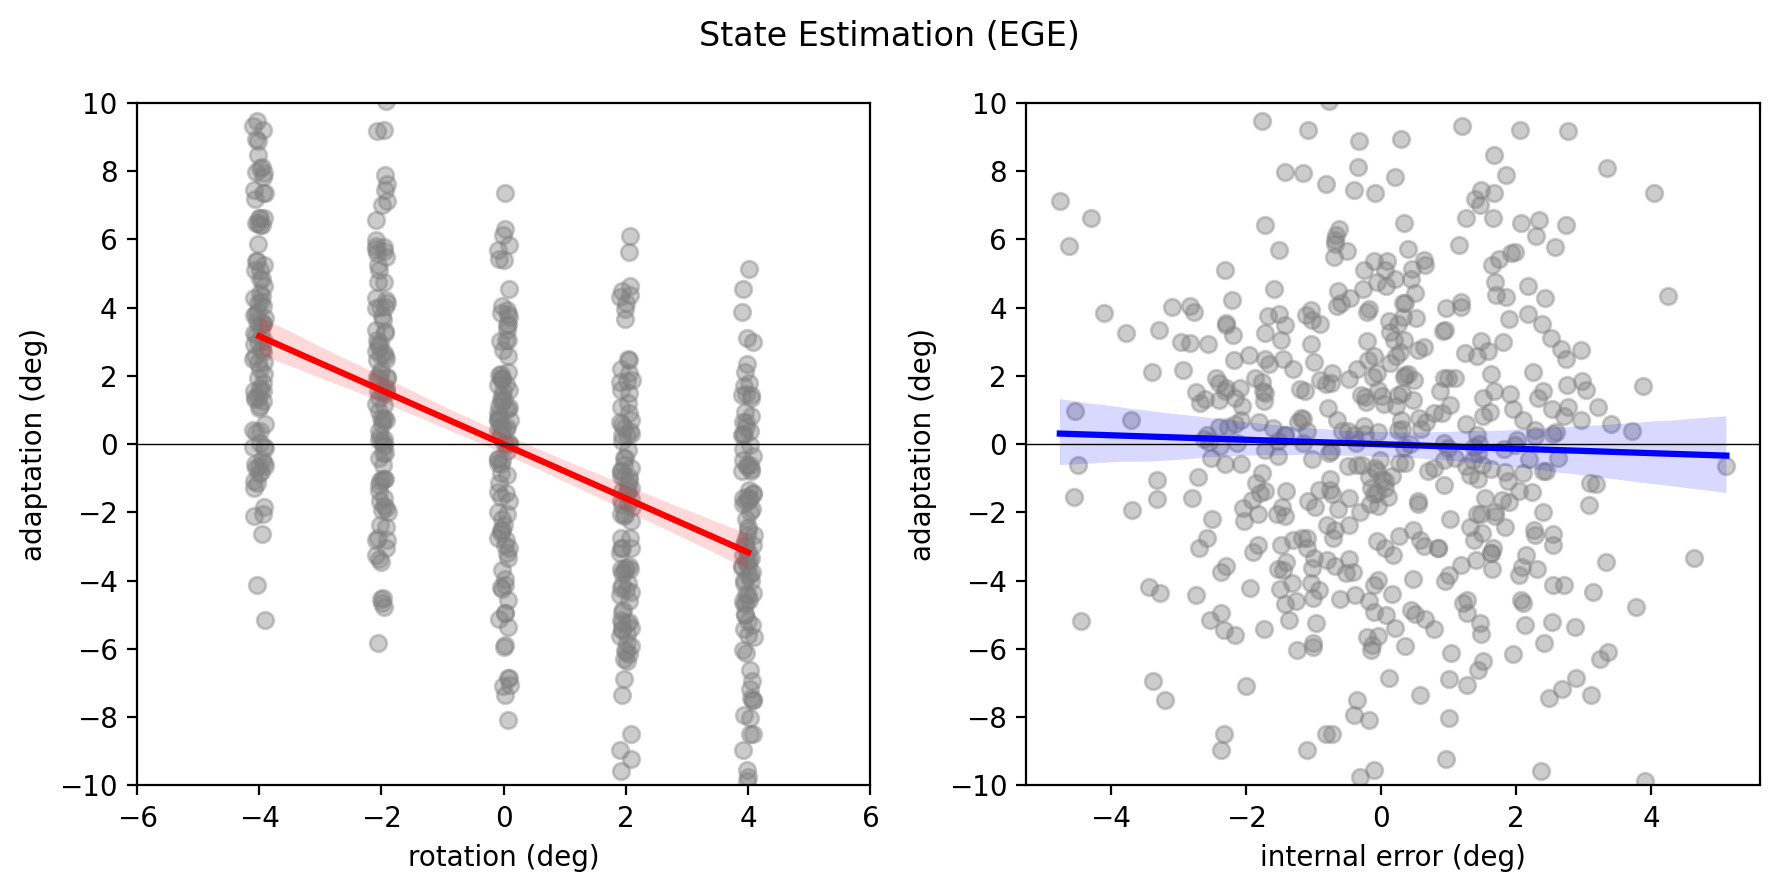

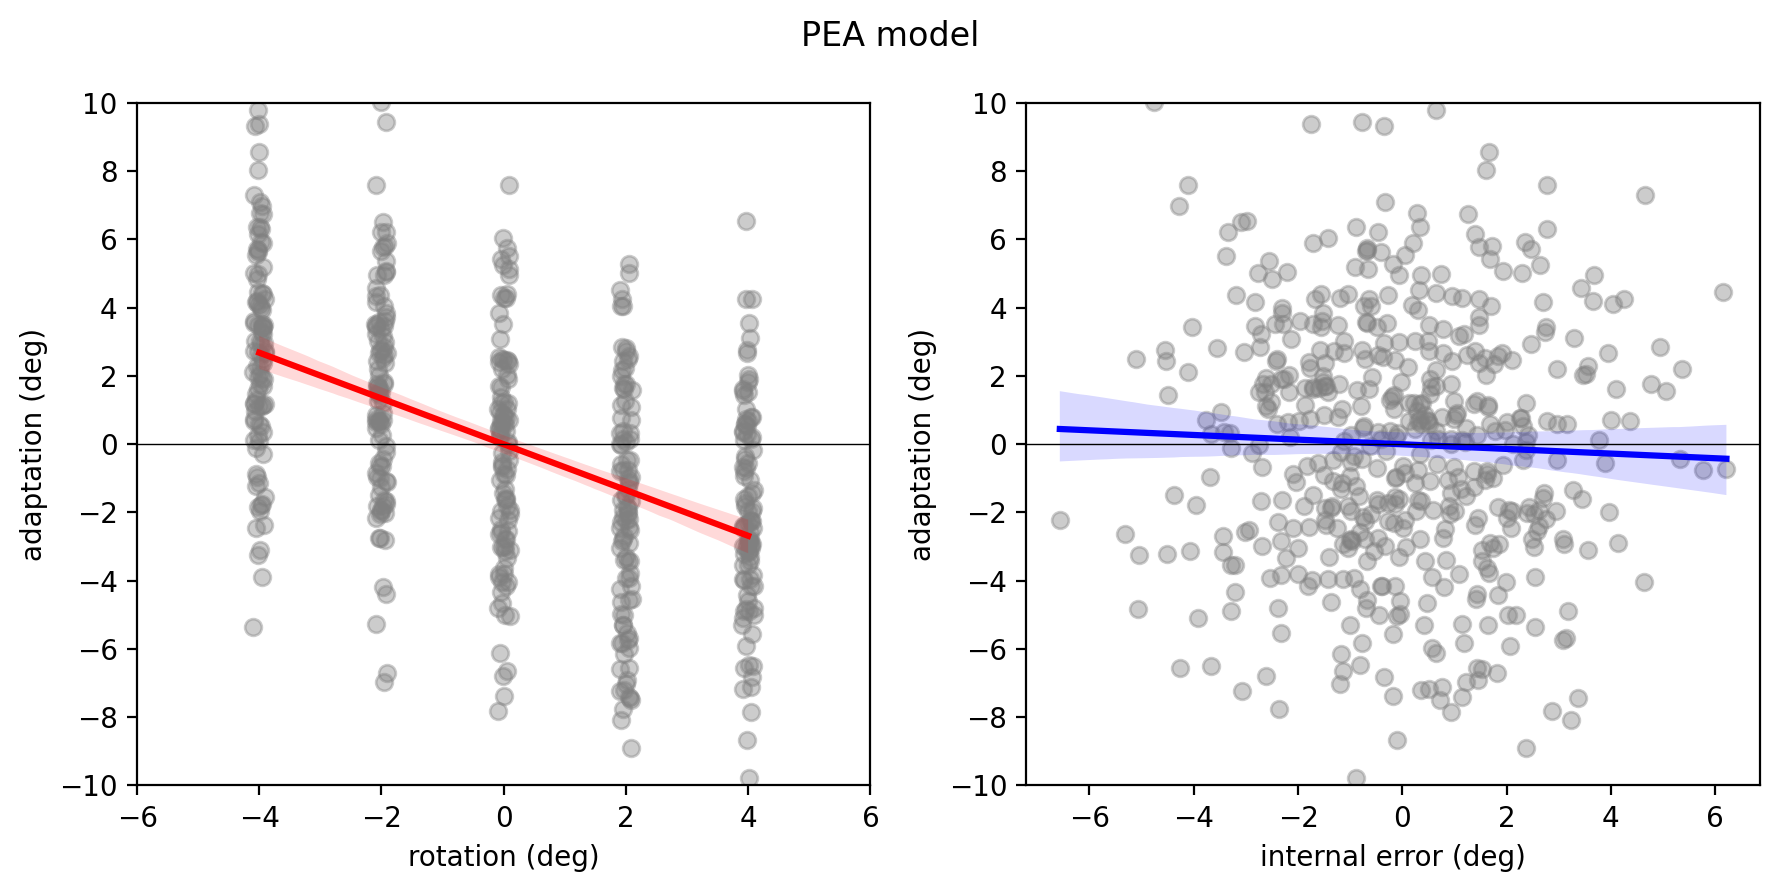

In [8]:
# State estimator (ege learner)
plot_individual(df_adapt, "delta_x", "x_hand_ege", "adapt_ege", "State Estimation (EGE)")

# PEA
plot_individual(df_adapt, "delta_x", "x_hand_pea", "adapt_pea", "PEA model")

---
# Maximum Likelihoood Estimation

Fit "data" found in `df`.

In [9]:
def state_ege(previous_state, ege, T, B, A=0):
    state_est = A * previous_state + B * (T - ege)
    
    return state_est


def ssm_ege(x_hand, rotation, B):
    e = np.zeros(len(x_hand))
    mu = np.zeros(len(x_hand))
    for i in range(1, len(x_hand)):
        if i == 0:
            mu[i] = 0
        else:
            e[i - 1] = rotation[i - 1]
            mu[i] = B * e[i - 1]
    
    return mu


def pea_expmt(sigma_int, B, num_trials, x_hand, vis_fb, delta_x, T):
    T = 0
    x_stl = np.zeros(num_trials)
    
    for i in range(num_trials - 1):
        if vis_fb[i] == 0:
            x_v = 0
            sigma_v = np.inf
        else:
            x_v = x_hand[i] + delta_x[i]
            sigma_v = 1.179 + 0.384 * np.abs(x_v)  # after Zhang et al

        w_int = (1 / sigma_int**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
        w_v = (1 / sigma_v**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
        xhat_hand = w_v * x_v 
        
        x_stl[i + 1] = B * (T - xhat_hand)
        
    return x_stl


def negloglik_ssm(B, sigma, x_hand, rotation, model):
    if model == "ssm":
        mu = ssm_ege(x_hand, rotation, B)

    nll = -np.sum(-1 / 2 * np.log(2 * np.pi * sigma**2) - ((x_hand - mu)**2 / (2 * sigma**2)))
    
    return nll


def negloglik_pea(sigma_int, B, num_trials, vis_fb, T, x_hand, rotation, model):
    if model == "pea":
        mu = pea_expmt(sigma_int, B, num_trials, x_hand, vis_fb, rotation, T)
        sigma = 1.8
    nll = -np.sum(-1 / 2 * np.log(2 * np.pi * sigma**2) - ((x_hand - mu)**2 / (2 * sigma**2)))
    
    return nll


In [10]:
# Write lambda function
T = 0
nll_ssm = lambda x: negloglik_ssm(x[0], x[1], df["x_hand_ege"], df["delta_x"], "ssm")
nll_pea = lambda x: negloglik_pea(x[0], x[1], num_trials, vis_fb, T, df["x_hand_pea"], df["delta_x"], "pea")
theta_ssm = scipy.optimize.fmin(func=nll_ssm, x0=np.array([0.1, 0.1]))
theta_pea = scipy.optimize.fmin(func=nll_pea, x0=np.array([7, 0.7]))
print(theta_ssm)
print(theta_pea)

# Assigne MLEs to variables
B_ege = theta_ssm[0]
sigma_est = theta_ssm[1]

Optimization terminated successfully.
         Current function value: 2026.166806
         Iterations: 54
         Function evaluations: 106
Optimization terminated successfully.
         Current function value: 2026.687951
         Iterations: 37
         Function evaluations: 68
[-0.73186133  1.8316623 ]
[6.62552337 0.74331334]


In [17]:
# Fit S1's actual data
nll_ssm = lambda x: negloglik_ssm(x[0], x[1], s1["theta_maxradv_clean"], s1["rotation"], "ssm")
nll_pea = lambda x: negloglik_pea(x[0], x[1], len(s1), s1["fbi"], T, s1["theta_maxradv_clean"], s1["rotation"], "pea")
ssm_s1 = scipy.optimize.fmin(func=nll_ssm, x0=np.array([0.1, 0.1]))
# pea_s1 = scipy.optimize.fmin(func=nll_pea, x0=np.array([4, 0.7]))
pea_s1 = scipy.optimize.minimize(
    fun=nll_pea, 
    x0=np.array([4, 0.7]), 
    method="Nelder-Mead", 
    bounds=((1, 20), (0, 1))
)

print(ssm_s1)
print(pea_s1)

Optimization terminated successfully.
         Current function value: 2695.035314
         Iterations: 59
         Function evaluations: 110
[-0.5937674   2.17601501]
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2931.204769123249
             x: [ 2.000e+01  1.522e-01]
           nit: 47
          nfev: 84
 final_simplex: (array([[ 2.000e+01,  1.522e-01],
                       [ 2.000e+01,  1.522e-01],
                       [ 2.000e+01,  1.523e-01]]), array([ 2.931e+03,  2.931e+03,  2.931e+03]))


In [12]:
# sigma_int_all = np.linspace(0.1, 10, 200)
# B_all = np.linspace(0, 1, 51)

# T = 0
# sigma_motor = 1.8
# logprobs_all = np.zeros((len(sigma_int_all), len(B_all), num_trials))
# ll_mat = np.zeros((len(sigma_int_all), len(B_all)))

# for i in range(len(sigma_int_all)):
#     for j in range(len(B_all)):
#         x_hand = df["x_hand_pea"]
#         x_stl = np.zeros(num_trials)
        
#         for k in range(num_trials - 1):
#             if vis_fb[k] == 0:
#                 x_v = 0
#                 sigma_v = np.inf
#             else:
#                 x_v = x_hand[k] + delta_x[k]
#                 sigma_v = 1.179 + 0.384 * np.abs(x_v)  # after Zhang et al

#             w_int = (1 / sigma_int_all[i]**2) / (1 / sigma_int_all[i]**2 + 1 / sigma_v**2)
#             w_v = (1 / sigma_v**2) / (1 / sigma_int_all[i]**2 + 1 / sigma_v**2)
#             xhat_hand = w_v * x_v
        
#             x_stl[k + 1] = B_all[j] * (T - xhat_hand)
            
#             logprobs_all[i, j, k] = -1 / 2 * np.log(2 * np.pi * sigma_motor**2) - ((x_hand[k] - x_stl[k])**2 / (2 * sigma_motor**2))

# ll_mat = np.sum(logprobs_all, axis=2)
# idx_sig, idx_B = np.unravel_index(np.argmax(ll_mat), shape=ll_mat.shape)
# sigma_int_mle = sigma_int_all[idx_sig]
# B_mle = B_all[idx_B]
# print(sigma_int_mle, B_mle)
# print(ll_mat[idx_sig, idx_B])
        

---
# Plot Models using Best-Fit Parameters

In [13]:
# Simulate with best-fit parameters
x = np.zeros(num_trials)
x_bestfit = simulate_experiment(num_trials, x, sigma_est, vis_fb, delta_x, -B_ege)
adaptation = calculate_adaptation(num_trials, n_per_miniblock, x_bestfit)

# Create data frame with all trials
df1 = pd.DataFrame({
    "delta_x":delta_x, "x_bestfit":x_bestfit, "adaptation": adaptation
})

# Create trimmed data frame without null trials
df2 = df1.iloc[1::n_per_miniblock].reset_index()
df2.head()

,index,delta_x,x_bestfit,adaptation
0,1,0.0,0.204064,1.633803
1,3,2.0,-3.835520,-3.767691
2,5,0.0,0.386910,5.925217
3,7,0.0,-3.538610,-1.214406
4,9,-4.0,-0.181342,0.391422


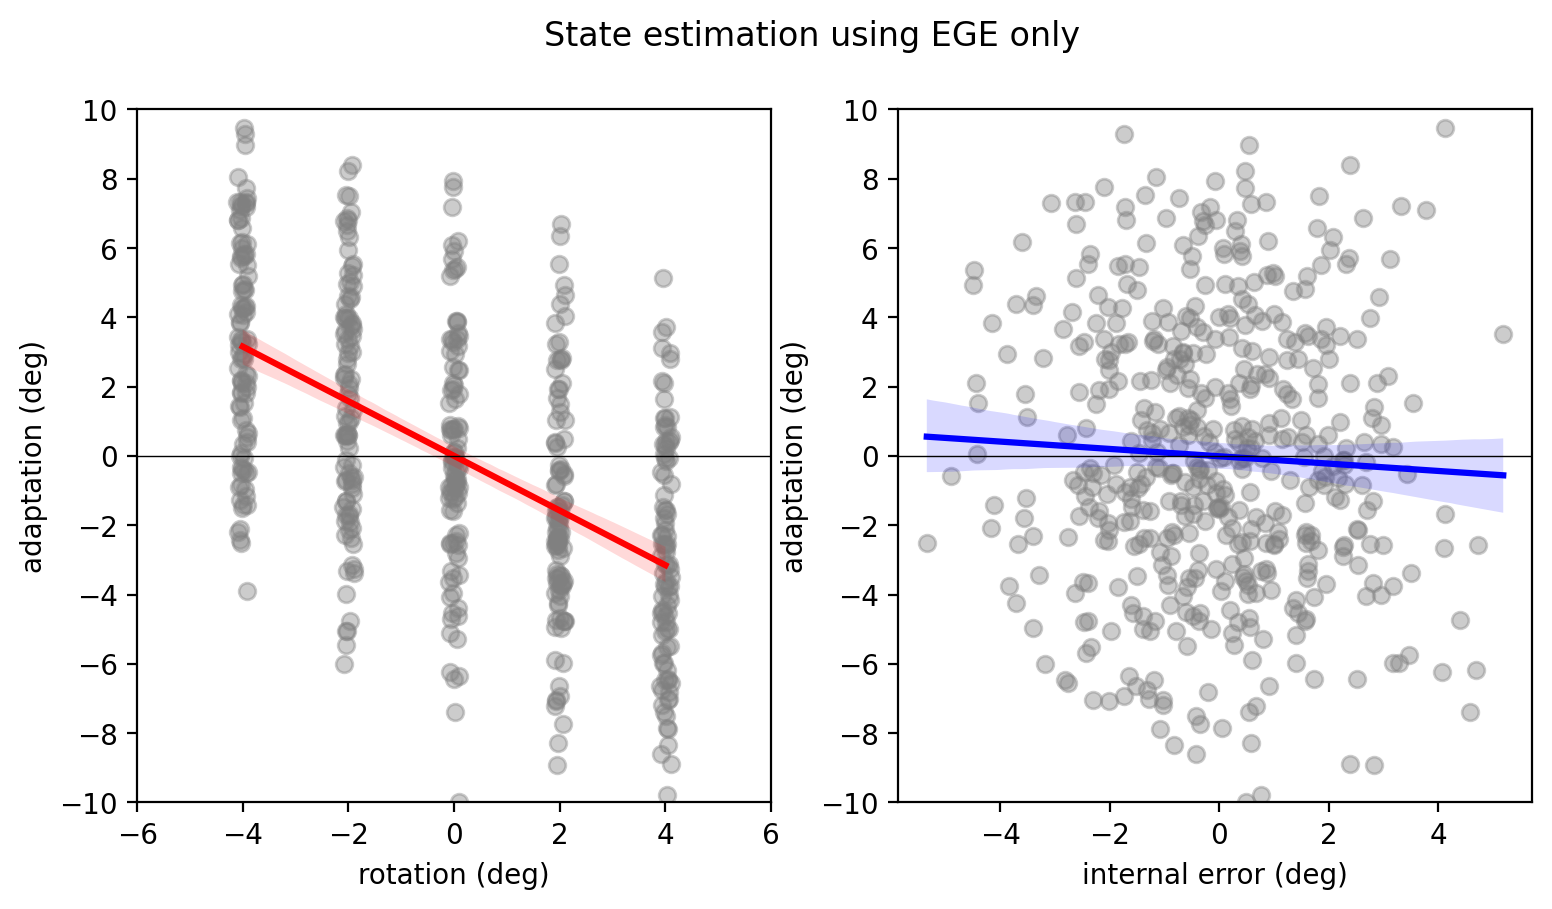

In [14]:
# State estimator (ege learner)
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))
sns.regplot(data=df2, x="delta_x", x_jitter=0.1, y="adaptation", 
               scatter_kws={"alpha":0.4, "color":"gray"},  line_kws={"color":"r"}, ax=axs[0])
axs[0].set(xlabel="rotation (deg)", ylabel="adaptation (deg)", xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), 
           ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2))
axs[0].axhline(color="k", linewidth=0.5)

sns.regplot(data=df2, x="x_bestfit", y="adaptation", line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="internal error (deg)", ylabel="adaptation (deg)")
axs[1].axhline(color="k", linewidth=0.5)

fig.suptitle("State estimation using EGE only")
plt.show()